In [1]:
%matplotlib inline

from config import configs

import os
import io
import numpy as np
import matplotlib
import timeit
import random
import cv2
import deepdish as dd

import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime
from pixor_targets import PIXORTargets
from skimage.transform import resize
from scipy.interpolate import griddata
from core.kitti import KITTI
from pixor_utils.model_utils import load_model, save_model
from data_utils.training_gen import TrainingGenerator
from data_utils.generator import Generator, KITTIGen, KITTICarRecognition2DGen
# from tt import bev
from data_utils.generator import KITTIGen, KITTIValGen
from data_utils.parallel_gen import KITTIParallelGen
from pixor_utils.post_processing import nms_bev
from test_utils.unittest import test_pc_encoder, test_target_encoder
from encoding_utils.pointcloud_encoder import OccupancyCuboidKITTI
from encoding_utils.voxelizer import BEVVoxelizer
from multiprocessing_generator import ParallelGenerator
from linetimer import CodeTimer

In [2]:
DS_DIR = os.path.expanduser(configs['dataset_path'])

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Point Cloud Encoder
INPUT_SHAPE = configs['input_shape']

# Training
BATCH_SIZE = configs['hyperparams']['batch_size']
LEARNING_RATE = configs['hyperparams']['lr']
EPOCHS = configs['hyperparams']['epochs']
NUM_THREADS = configs['hyperparams']['num_threads']
MAX_Q_SIZE = configs['hyperparams']['max_q_size']

In [4]:
kitti = KITTI(DS_DIR, configs['training_target'])

train_ids = kitti.get_ids('train')
val_ids = kitti.get_ids('val')
micro_ids = kitti.get_ids('micro')

In [5]:
pc_encoder = OccupancyCuboidKITTI(0, 70, -40, 40, -1, 3, [0.1, 0.1, 0.4]) # 0.1, 0.1, 0.4
pc_encoder = BEVVoxelizer(n_x=448, n_y=512, n_z=32, side_range=(0,70), fwd_range=(-40,40), height_range=(-1, 3), filter_external=True)

In [23]:
pts, ref = kitti.get_velo(train_ids[25], workspace_lim=((-35, 35), (-1, 3), (0, 70)), use_fov_filter=True)  # Load velo
_, _, P2 = kitti.get_calib(train_ids[25])

a_s = timeit.default_timer()
start = timeit.default_timer()
depth_map = kitti.get_range_view(img=None, pts=pts, ref=ref, P2=P2, gt_boxes=None, pred_boxes=None, out_type='depth')
print('depth_map in:', timeit.default_timer() - start)

start = timeit.default_timer()
intensity_map = kitti.get_range_view(img=None, pts=pts, ref=ref, P2=P2, gt_boxes=None, pred_boxes=None, out_type='intensity')
print('intensity_map in:', timeit.default_timer() - start)

start = timeit.default_timer()
height_map = kitti.get_range_view(img=None, pts=pts, ref=ref, P2=P2, gt_boxes=None, pred_boxes=None, out_type='height')
print('height_map in:', timeit.default_timer() - start)

print('all took', timeit.default_timer() - a_s)

depth_map in: 0.07024338841438293
intensity_map in: 0.08307474106550217
height_map in: 0.07716797851026058
all took 0.23086541146039963


In [24]:
voxelizer  = BEVVoxelizer(n_x=448, n_y=512, n_z=32, side_range=(0,70), fwd_range=(-40,40), height_range=(-1, 3), filter_external=True)

In [25]:
with CodeTimer():
    voxelized_pc = voxelizer.encode(pts)

Code block took: 34.98816 ms


In [26]:
bev = np.sum(voxelized_pc, axis=2)
bev = bev / np.amax(bev)
print(bev.shape)

(448, 512)


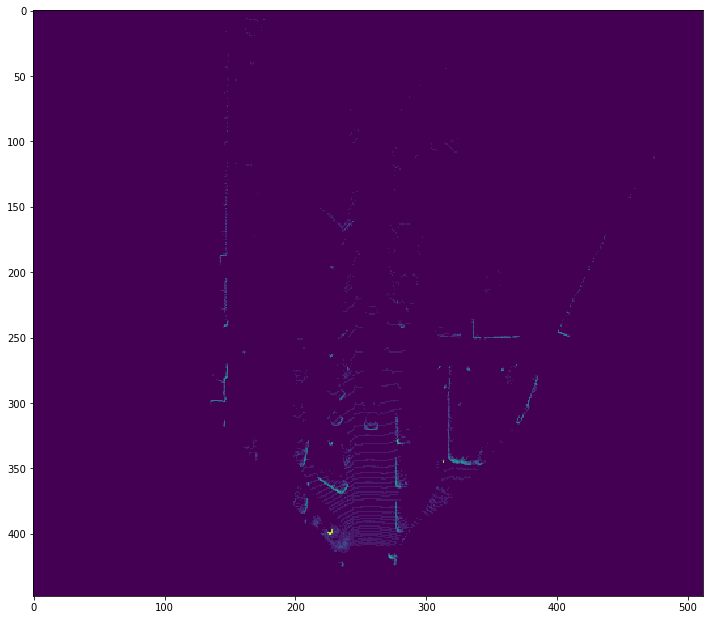

In [27]:
plt.figure(figsize = (12, 12))
plt.imshow(bev)